# convnet visualization
### intermediate activations

In [1]:
from keras.models import load_model

model = load_model('./dogscats_regularized.h5')
model.summary()

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [2]:
from keras.preprocessing import image
import numpy as np

img = image.load_img('./dogs-vs-cats/test/cat/cat.1642.jpg', target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


In [4]:
import matplotlib.pyplot as plt

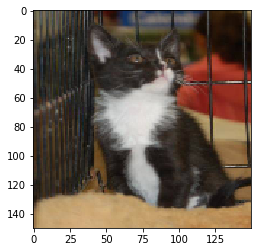

In [5]:
plt.imshow(img_tensor[0])
plt.show()

In [7]:
from keras import models

In [8]:
output_layers = [l.output for l in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=output_layers)

In [10]:
activations = activation_model.predict(img_tensor)
print(len(activations))
print(activations[0].shape)

8
(1, 148, 148, 32)


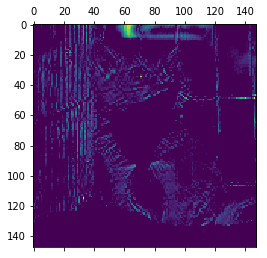

In [11]:
plt.matshow(activations[0][0,:,:,11], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


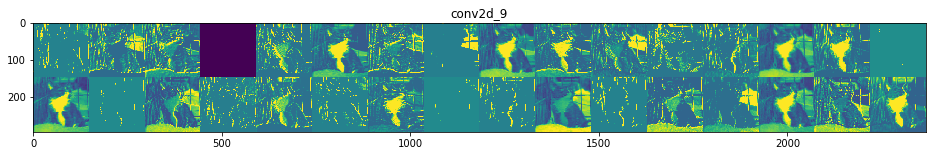

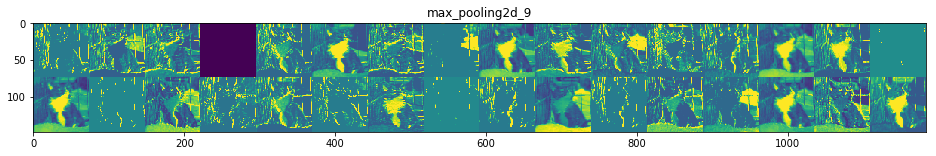

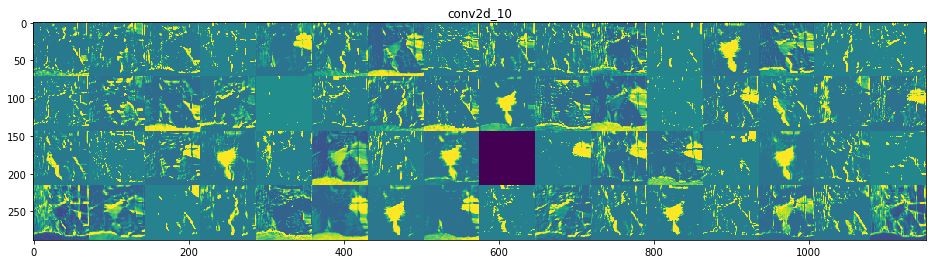

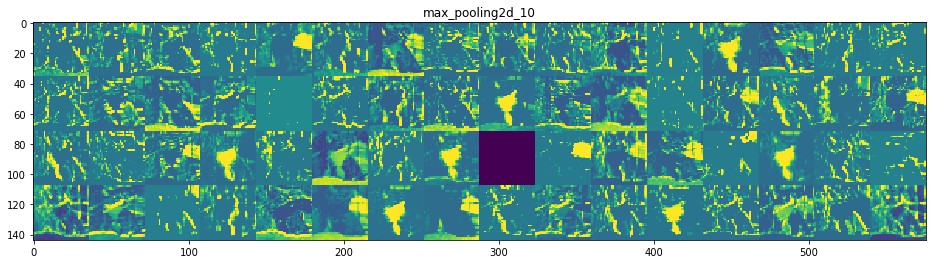

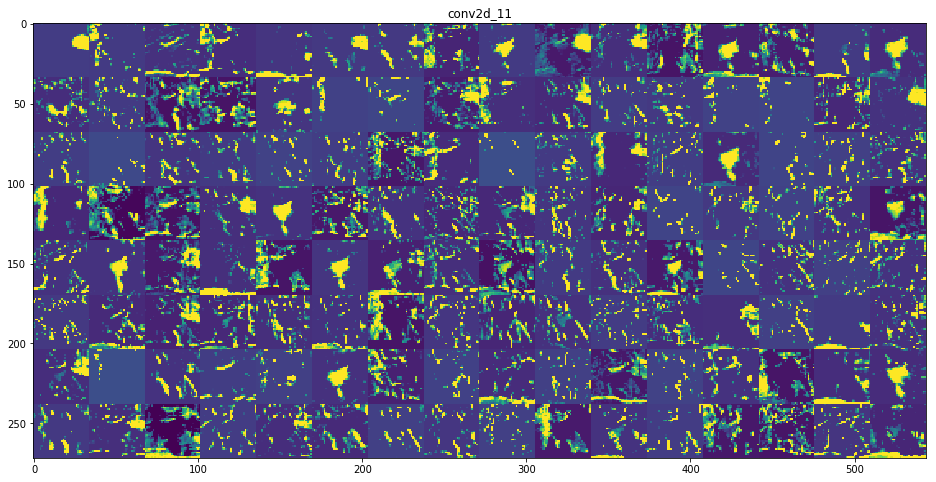

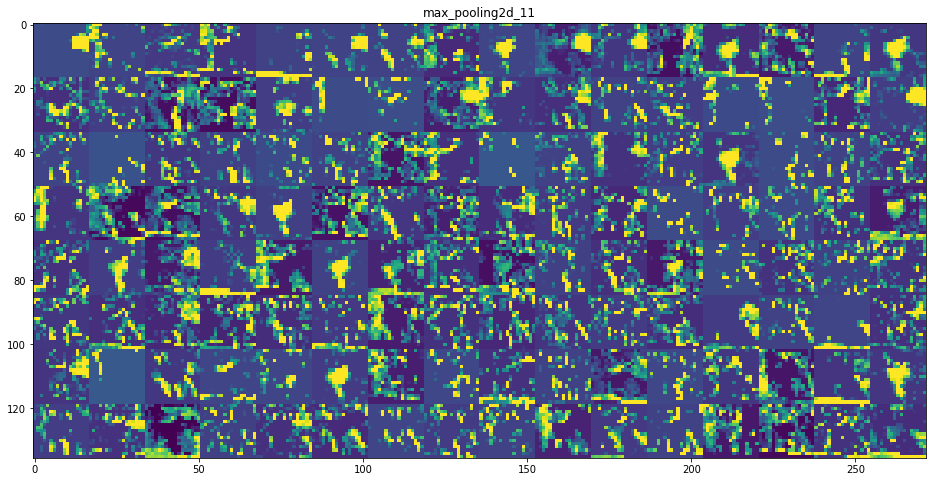

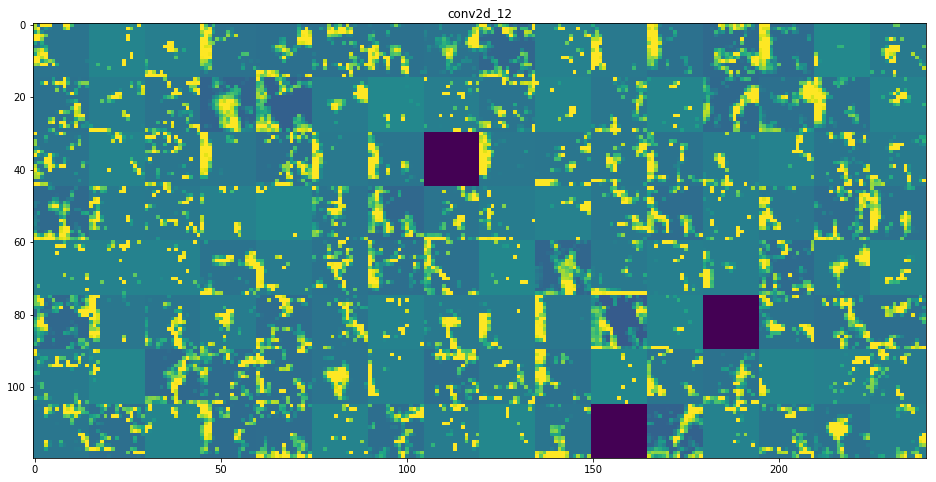

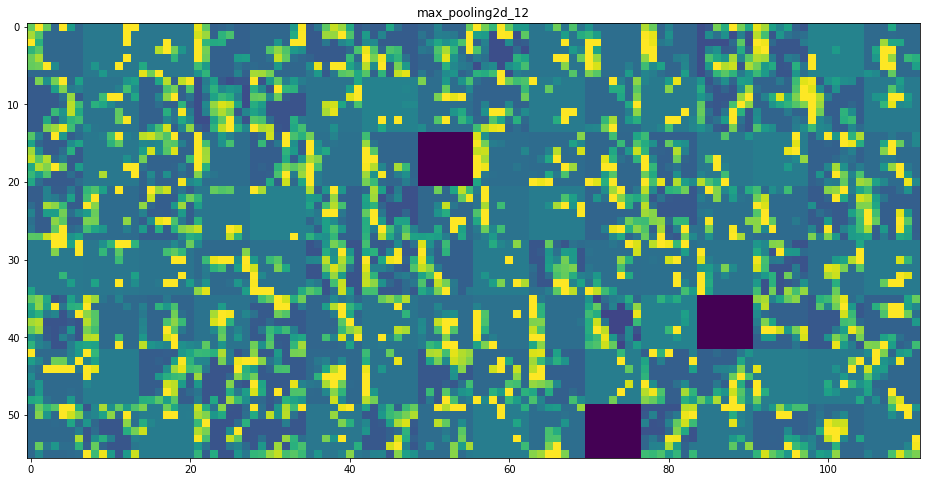

In [12]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):

    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### visualize convnet filters

In [31]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np

In [37]:
def deprocess_img(x):
    x -= x.mean()
    x /= x.std()
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [42]:
model = VGG16(include_top=False, weights='imagenet')

In [53]:
def generate_pattern(layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    step = 1.
    input_img = np.random.random((1,size,size,3))*20 + 128
    for i in range(40):
        loss_value, grads_value = iterate([input_img])
        input_img += grads_value * step
    
    return deprocess_img(input_img[0])

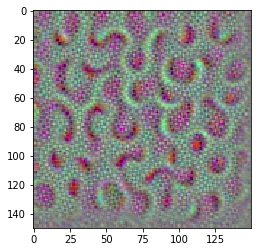

In [54]:
plt.imshow(generate_pattern('block4_conv1', 0))

In [68]:
def plot_layer(layer_name):
    size = 64
    grid = 8
    margin = 5

    results = np.zeros((grid*size + (grid-1)*margin, grid*size + (grid-1)*margin, 3), dtype=np.uint8)

    for i in range(grid):
        for j in range(grid):
            filter_img = generate_pattern(layer_name, i + j * grid, size=size)
            
            h_start = i*size + i*margin
            h_end = h_start + size
            v_start = j*size + j*margin
            v_end = v_start + size
            
            results[h_start:h_end,v_start:v_end, :] = filter_img
      
    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

255
<class 'numpy.uint8'>


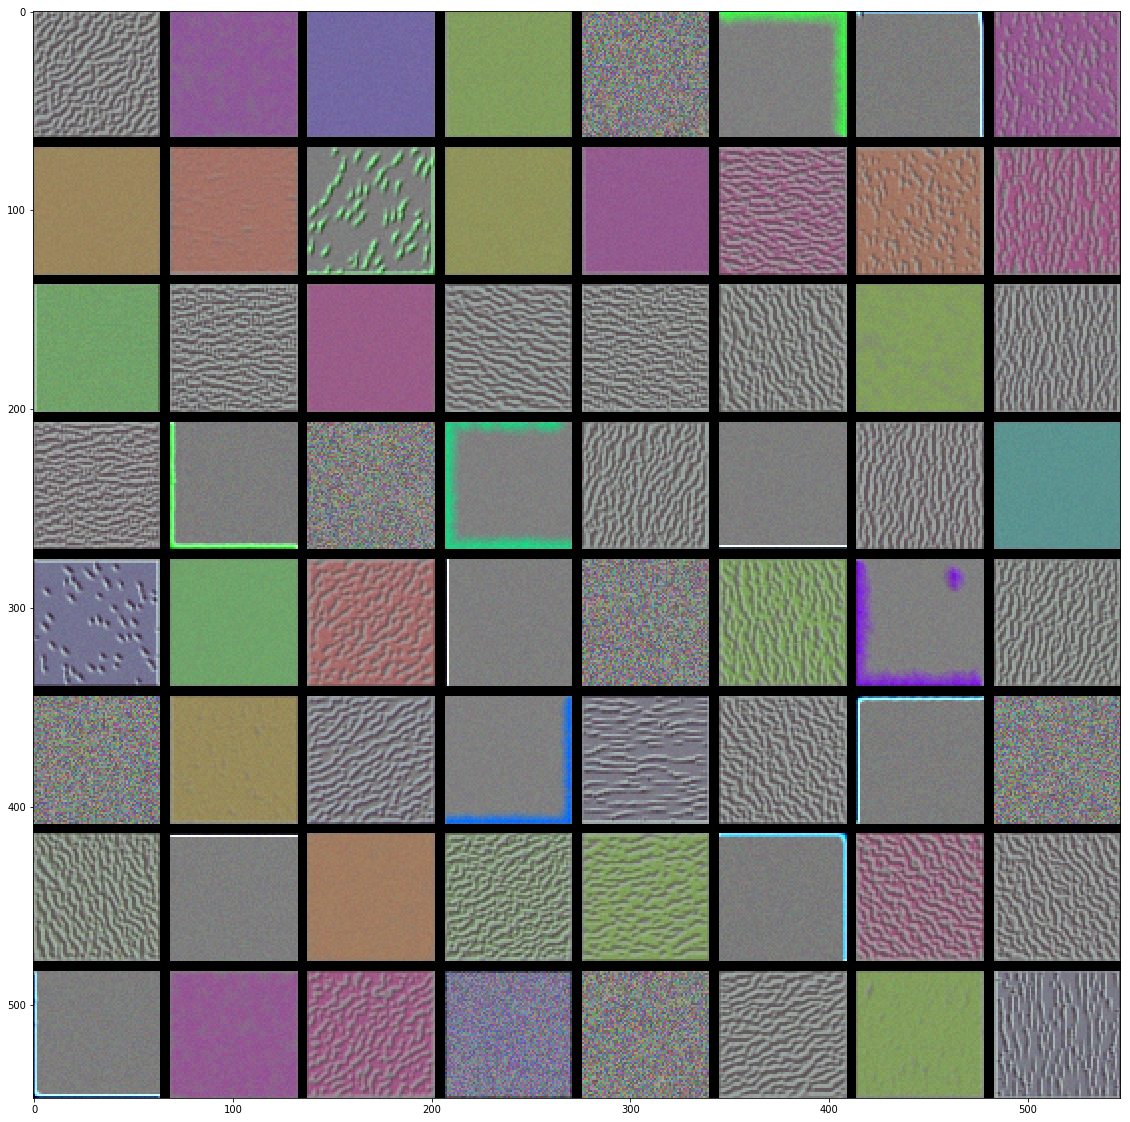

In [66]:
plot_layer('block1_conv1')

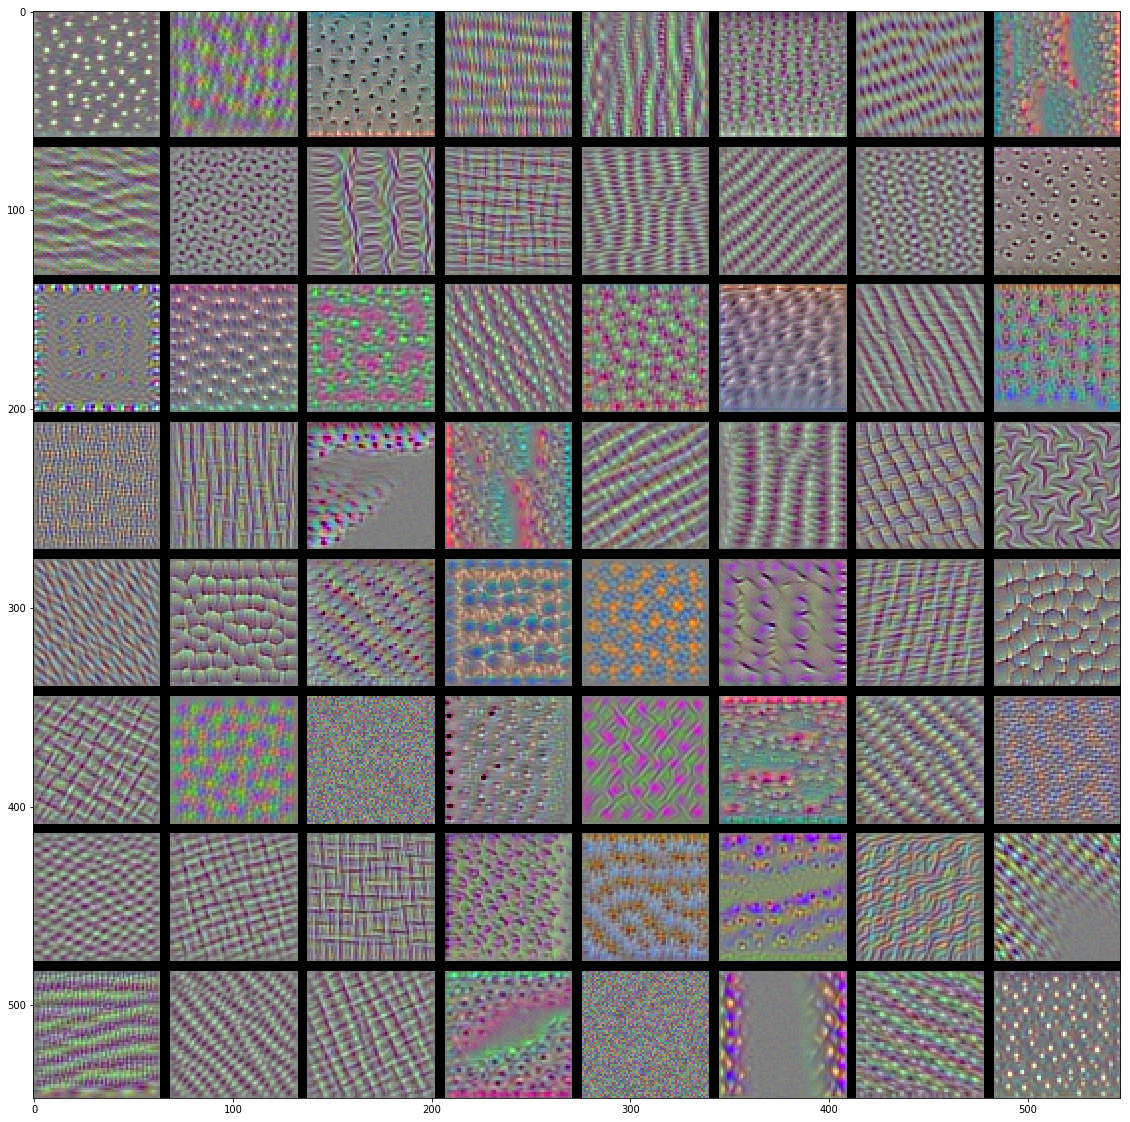

In [69]:
plot_layer('block3_conv1')

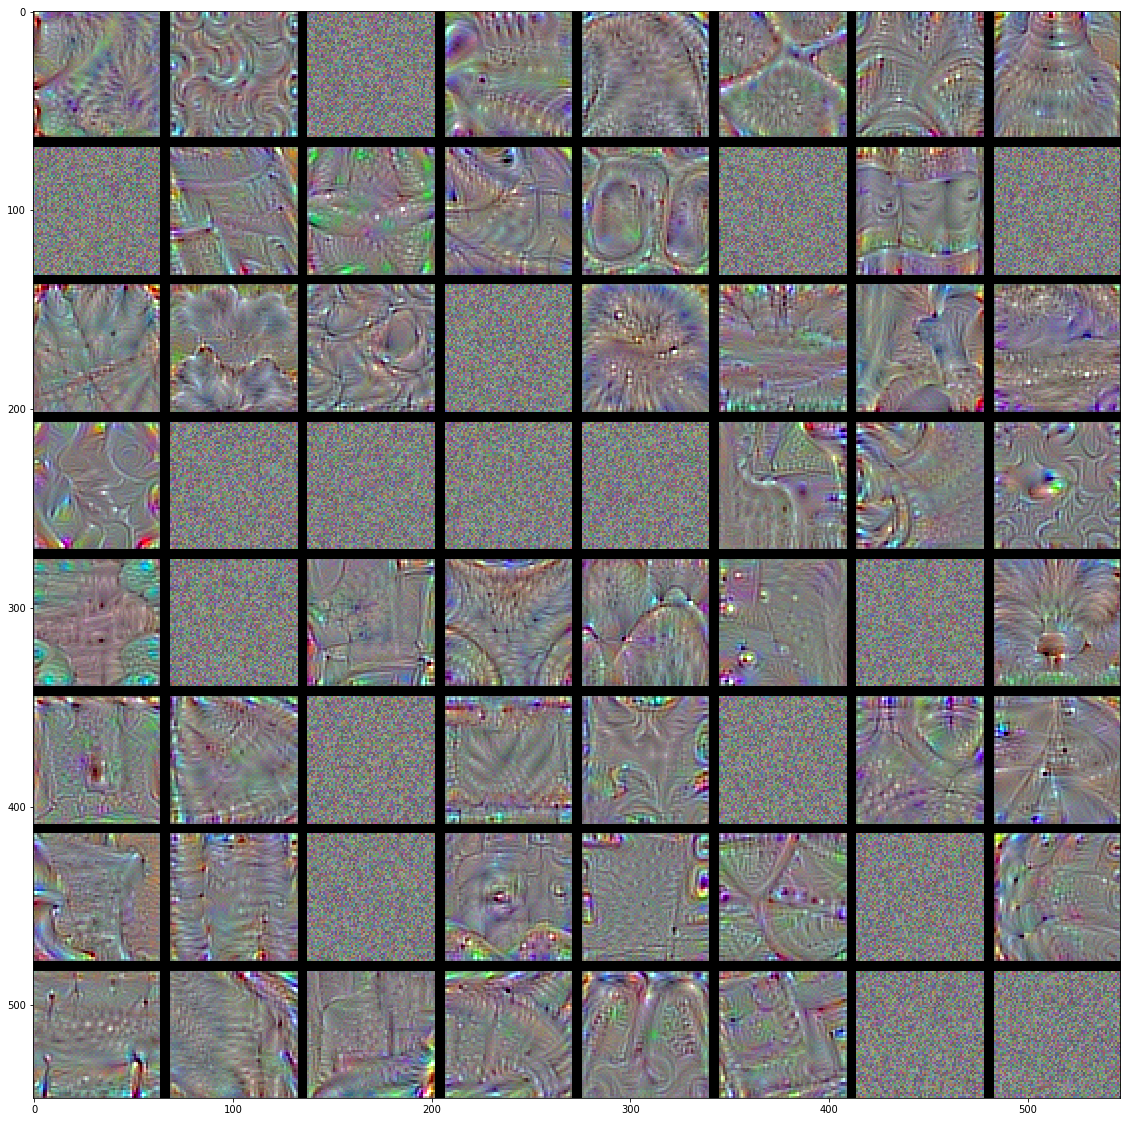

In [70]:
plot_layer('block5_conv1')

### class activation heatmaps

In [73]:
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [ ]:
model = VGG16(weights='imagenet')

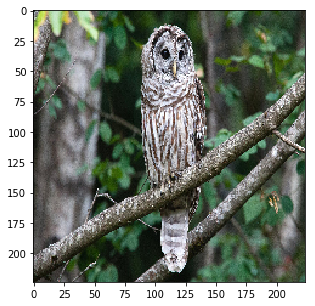

In [78]:
import matplotlib.pyplot as plt

img = image.load_img('./owl.jpg', target_size=(224,224))
plt.imshow(img)

In [75]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(decode_predictions(preds)[0])

40960/35363 [==================================] - 0s 4us/step
[('n01622779', 'great_grey_owl', 0.98553723), ('n01688243', 'frilled_lizard', 0.0035062179), ('n01532829', 'house_finch', 0.0022159545), ('n01687978', 'agama', 0.0014993312), ('n01797886', 'ruffed_grouse', 0.001268718)]


In [79]:
np.argmax(preds[0])

24

In [82]:
model.get_layer('block5_conv3').output

<tf.Tensor 'block5_conv3_4/Relu:0' shape=(?, 14, 14, 512) dtype=float32>

In [102]:
gg_owl_output = model.output[:, 24]

last_conv = model.get_layer('block5_conv3')
grads = K.gradients(gg_owl_output, last_conv.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input], [pooled_grads, last_conv.output[0]])

pooled_grads_value, last_conv_value = iterate([x])

for i in range(len(pooled_grads_value)):
    last_conv_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(last_conv_value, axis=-1)

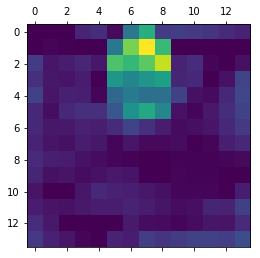

In [103]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

In [94]:
import cv2

In [104]:
img = cv2.imread('./owl.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(heatmap*255)
heatmap = cv2.applyColorMap(heatmap, colormap=cv2.COLORMAP_JET)

superimposed = 0.4 * heatmap + img

cv2.imwrite('./imposed_owl.jpg', superimposed)

True

<img src="./imposed_owl.jpg" width="640" height="960">